# Intensive Module in Machine Learning
# Problem set 3: Regularisation 

If you are looking at the pdf/html version of this document, start by running the command `jupyter notebook` to launch an interactive notebook and then navigate to the correct folder and open this file `problem-set-3.ipynb`. Import your default packages for manipulating data and plotting:

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 

## 1. Subset selection

Let us return to the California Housing data set with the data splitted into train and test set as before. Our aim is to perform subset selection on the features.

In [8]:
data = pd.read_csv('California-Housing.txt', sep=",")
data.head()

#Fix random seed for reproducability
np.seed = 200000
#Split data into training and testing data
mask = np.random.rand(len(data)) < 0.8
train = data[mask]
test = data[~mask]

X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

a) Perform best subset selection on the linear regression model. Plot test error as a function of number of (optimal) predictors.

<span style="color:blue"> We can perform best subset selection by identifying the best model that contains a given number of predictors, where best is quantified using test set error. We'll define a helper function to outputs the best set of variables for each model size: </span>

In [30]:
import statsmodels.api as sm

def fit_subset(feature_set):
    # Fit model on feature_set and calculate test error
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    test_error = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "test_error": test_error}

/Users/ablaas/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [31]:
import itertools

def best_model(k):
    #Takes number of features k and after fitting all possible combinations of k feature models to data,
    #outputs the model with the lowest test set error
    results = []
    for combination in itertools.combinations(X_train.columns, k):
        results.append(fit_subset(combination))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['test_error'].argmin()]
    return best_model


In [40]:
# Lets get the best model for each k using a for loop

models_best = pd.DataFrame(columns=["test_error", "model"])

for i in range(1,8):
    models_best.loc[i] = best_model(i)

<span style="color:blue"> For any number k, we can now inspect, which subset of k features was selected because it had the lowest test error. </span>

In [39]:
print(models_best.loc[4, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:       MedianHouseValue   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 3.364e+04
Date:                Thu, 22 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:23:04   Log-Likelihood:                -16593.
No. Observations:               15714   AIC:                         3.319e+04
Df Residuals:                   15710   BIC:                         3.322e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
MedianIncome          0.5002      0.00

b) What are some of the shortcomings of best subset selection in practice?

<span style="color:blue"> Most importantly, the number of models fitted increases exponentially with the number of features in the data set, as the number of possible subsets of k variables out of n variables grows exponentially in n. This means for large number of features we can not implement this method as it would take too long. Additionally, test set is created randomly from data, so running best subset selection on one test set could give arbitrary results. Running it on multiple test sets (cross validation) can further inflate computational cost. </span>

.

## 2. Rigid regression and lasso

a) Perform rigid regression on the Housing data set used as above.

In [134]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

print('Test error =',mean_squared_error(model.predict(X_test), y_test))

Test error = 0.407471811562


b) Plot the test error as a function of the shrinkage parameter $\lambda$. How is model complexity related to the shrinkage parameter?

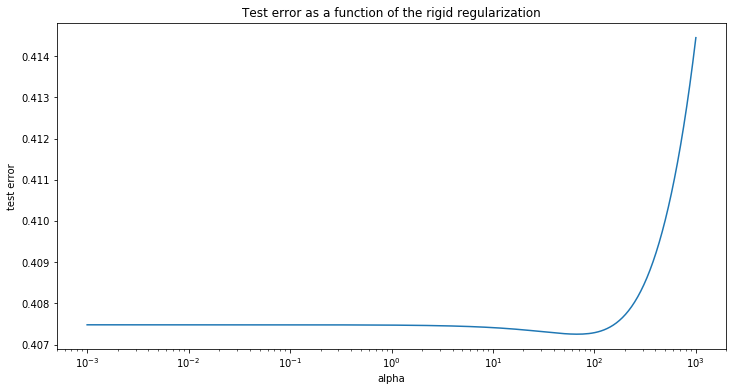

In [135]:
test_errors = []

alphas = np.logspace(-3, 3, 200)

# Train the model with different regularisation strengths
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X_train, y_train)
    test_errors.append(mean_squared_error(model.predict(X_test), y_test))
    
plt.figure(figsize=(12, 6))

ax = plt.gca()
ax.plot(alphas, test_errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('test error')
plt.title('Test error as a function of the rigid regularization')
#plt.axis('tight')

plt.show()

c) Now repeat the above analysis using lasso regression.

Test error = 0.396442427777


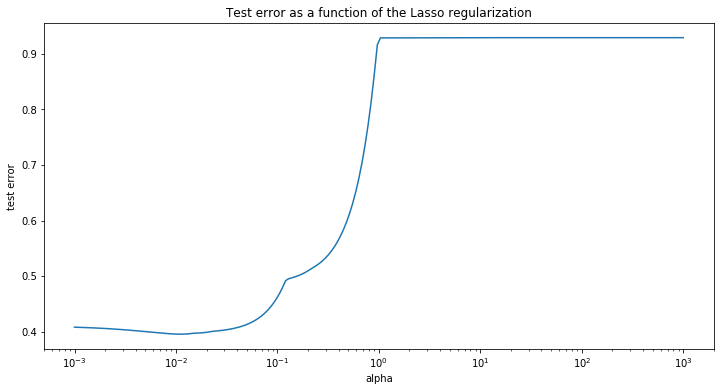

In [59]:
from sklearn.linear_model import Lasso

model2 = Lasso(alpha=1.0)
model2.fit(X_train, y_train)

print('Test error =',mean_squared_error(model.predict(X_test), y_test))

test_errors = []

alphas = np.logspace(-3, 3, 200)

# Train the model with different regularisation strengths
for a in alphas:
    model2.set_params(alpha=a)
    model2.fit(X_train, y_train)
    test_errors.append(mean_squared_error(model2.predict(X_test), y_test))
    
plt.figure(figsize=(12, 6))

ax = plt.gca()
ax.plot(alphas, test_errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('test error')
plt.title('Test error as a function of the Lasso regularization')
#plt.axis('tight')

plt.show()

d) Lasso automatically shrinks some of the parameters to zero, thus effectively performing subset selection. Which are the optimal predictors of the best model and how does this compare to the results from exercise 1?

In [63]:
model2.set_params(alpha=0.03)
model2.fit(X_train, y_train)

print(model2.coef_)

[  3.66457137e-01   9.56054070e-03   0.00000000e+00   0.00000000e+00
   9.28154231e-06  -2.88017166e-03  -3.12587957e-01  -3.15906890e-01]


## 3. High-dimensional data

In this case study we look at the [Arcene data set](http://archive.ics.uci.edu/ml/datasets/Arcene) which is a nice example of high-dimensional data (see [Arcene data set webpage](http://archive.ics.uci.edu/ml/datasets/Arcene) for more information). The Arcene data set is data for a classification problem where we want to infer cancer (label `1`) or no cancer (label `-1`) from mass-spectroscopy data. The training set consists of only n=100 observations. However, the mass-spectrometric data gives rise to p=10000 predictors. Thus we have a typical example of high-dimensional data with $p\gg n$.

a) Load the data, both train and valiadation set, and familiarise yourself with it. Potentially do some descriptive analysis and plots.

In [103]:
#Let's load the data
train_data = pd.read_csv('./Arcene-data/arcene_train.data.txt', sep=" ", header= None)
train_data = train_data.iloc[:, :-1]
train_labels = np.squeeze(pd.read_csv('./Arcene-data/arcene_train.labels.txt', sep=" ", header= None))

validation_data = pd.read_csv('./Arcene-data/arcene_valid.data.txt', sep=" ", header= None)
validation_data = validation_data.iloc[:, :-1]
validation_labels = np.squeeze(pd.read_csv('./Arcene-data/arcene_valid.labels.txt', sep=" ", header= None))

test_data = pd.read_csv('./Arcene-data/arcene_test.data.txt', sep=" ", header= None)
test_data = test_data.iloc[:, :-1]

#Let's check out the first few rows of the training data to see what the data looks like
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,71,0,95,0,538,404,20,0,0,...,255,570,86,0,36,0,80,0,0,524
1,0,41,82,165,60,554,379,0,71,0,...,213,605,69,7,473,0,57,0,284,423
2,0,0,1,40,0,451,402,0,0,0,...,235,593,28,0,24,0,90,0,34,508
3,0,56,44,275,14,511,470,0,0,0,...,91,600,0,26,86,0,102,0,0,469
4,105,0,141,348,0,268,329,0,0,1,...,813,0,0,0,0,190,301,0,0,354


In [104]:
#Let's look at some descriptions as well
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
count,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,37.060000,35.330000,56.50000,329.860000,17.110000,412.090000,232.330000,6.510000,48.170000,63.690000,...,363.780000,396.480000,45.920000,18.210000,106.070000,165.350000,197.650000,0.360000,88.530000,365.750000
std,49.763647,37.690943,68.64011,164.264508,26.348057,108.375152,186.106142,13.149102,57.624009,91.626349,...,262.439741,233.176462,47.886161,23.914112,141.747054,145.380752,113.122118,2.110675,109.698619,106.055386
min,0.000000,0.000000,0.00000,27.000000,0.000000,181.000000,0.000000,0.000000,0.000000,0.000000,...,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,213.750000,0.000000,314.250000,0.000000,0.000000,0.000000,0.000000,...,192.500000,309.000000,0.000000,0.000000,0.000000,0.000000,94.500000,0.000000,0.000000,314.500000
50%,15.000000,25.000000,19.50000,333.500000,0.000000,441.000000,266.000000,0.000000,30.000000,0.500000,...,250.000000,468.500000,34.500000,2.500000,48.500000,186.000000,167.000000,0.000000,38.500000,364.500000
75%,57.500000,59.750000,107.25000,443.000000,29.000000,501.250000,422.750000,4.500000,79.250000,125.000000,...,482.000000,579.250000,75.250000,34.250000,140.000000,276.500000,295.750000,0.000000,165.500000,446.500000
max,188.000000,218.000000,236.00000,677.000000,99.000000,583.000000,493.000000,55.000000,202.000000,391.000000,...,863.000000,654.000000,195.000000,83.000000,656.000000,485.000000,422.000000,18.000000,392.000000,533.000000


b) So far we focused on lasso for regression, but we can also apply the l1 regulariser to logistic regression as is needed for a classification problem like the one above. Perform lasso logistic regression on the above training data. Plot the test error as a function of the shrinkage parameter. What is your best model. 

Validation error = 0.15


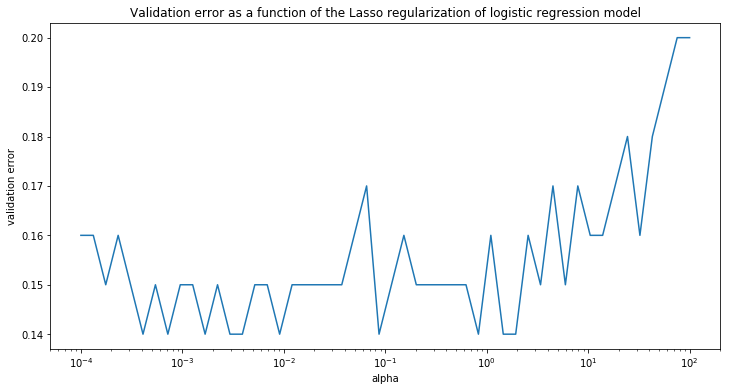

In [118]:
from sklearn.linear_model import LogisticRegression

model3 = LogisticRegression(penalty='l1', tol=0.01, solver='saga')
model3.fit(train_data, train_labels)

print('Validation error =',1-model3.score(validation_data,validation_labels) )

validation_errors = []

alphas = np.logspace(-4, 2, 50)

# Train the model with different regularisation strengths
for a in alphas:
    model3.set_params(C=1.0/a)
    model3.fit(train_data, train_labels)
    validation_errors.append(1-model3.score(validation_data,validation_labels))
    
plt.figure(figsize=(12, 6))

ax = plt.gca()
ax.plot(alphas, validation_errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('validation error')
plt.title('Validation error as a function of the Lasso regularization of logistic regression model')
#plt.axis('tight')

plt.show()

<span style="color:blue"> Validation accuracy clearly starts to degrade beyond $\alpha > 1$, but between $0.001$ and $1$ the differences seem to depend on optimisation initialisations. Therefore we select $\alpha = 1$, which penalises the most and thereby reduces the dimensionality of our model the most, as our preferred model. </span>

c) For your best model: Investigate the fitted coefficients. Which predictors are relevant for inferring the response variable?

In [131]:
#First, fit model again for alpha = 1
model3.set_params(C=1.0)
model3.fit(train_data, train_labels)

len(model3.coef_[0][model3.coef_[0]!=0.0])

9842

<span style="color:blue"> Almost all predictors remain relevant with this Lasso regularised logistic regression model, only 168 have been removed. </span>